In [132]:
!pip3 install matplotlib

In [133]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import sys
import math

origData = []
FILTER_SIZE = 31
FIG_SIZE = (42, 13)
FRAME_SIZE = 180
FRAME_LEN = 160

In [134]:
wfOrig = wave.open("raw_voice.wav", 'r')
origCh = wfOrig.getnchannels()
origSmpl = wfOrig.getsampwidth()
origRate = wfOrig.getframerate()
origNFrames = wfOrig.getnframes()
origData = wfOrig.readframes(origNFrames)
wfOrig.close()
print(f"Orig\n channels: {origCh}\n samples width: {origSmpl}\n frame rate: {origRate}\n frames: {origNFrames}\n data len: {len(origData)}")

Orig
 channels: 1
 samples width: 2
 frame rate: 8000
 frames: 1073741824
 data len: 485120


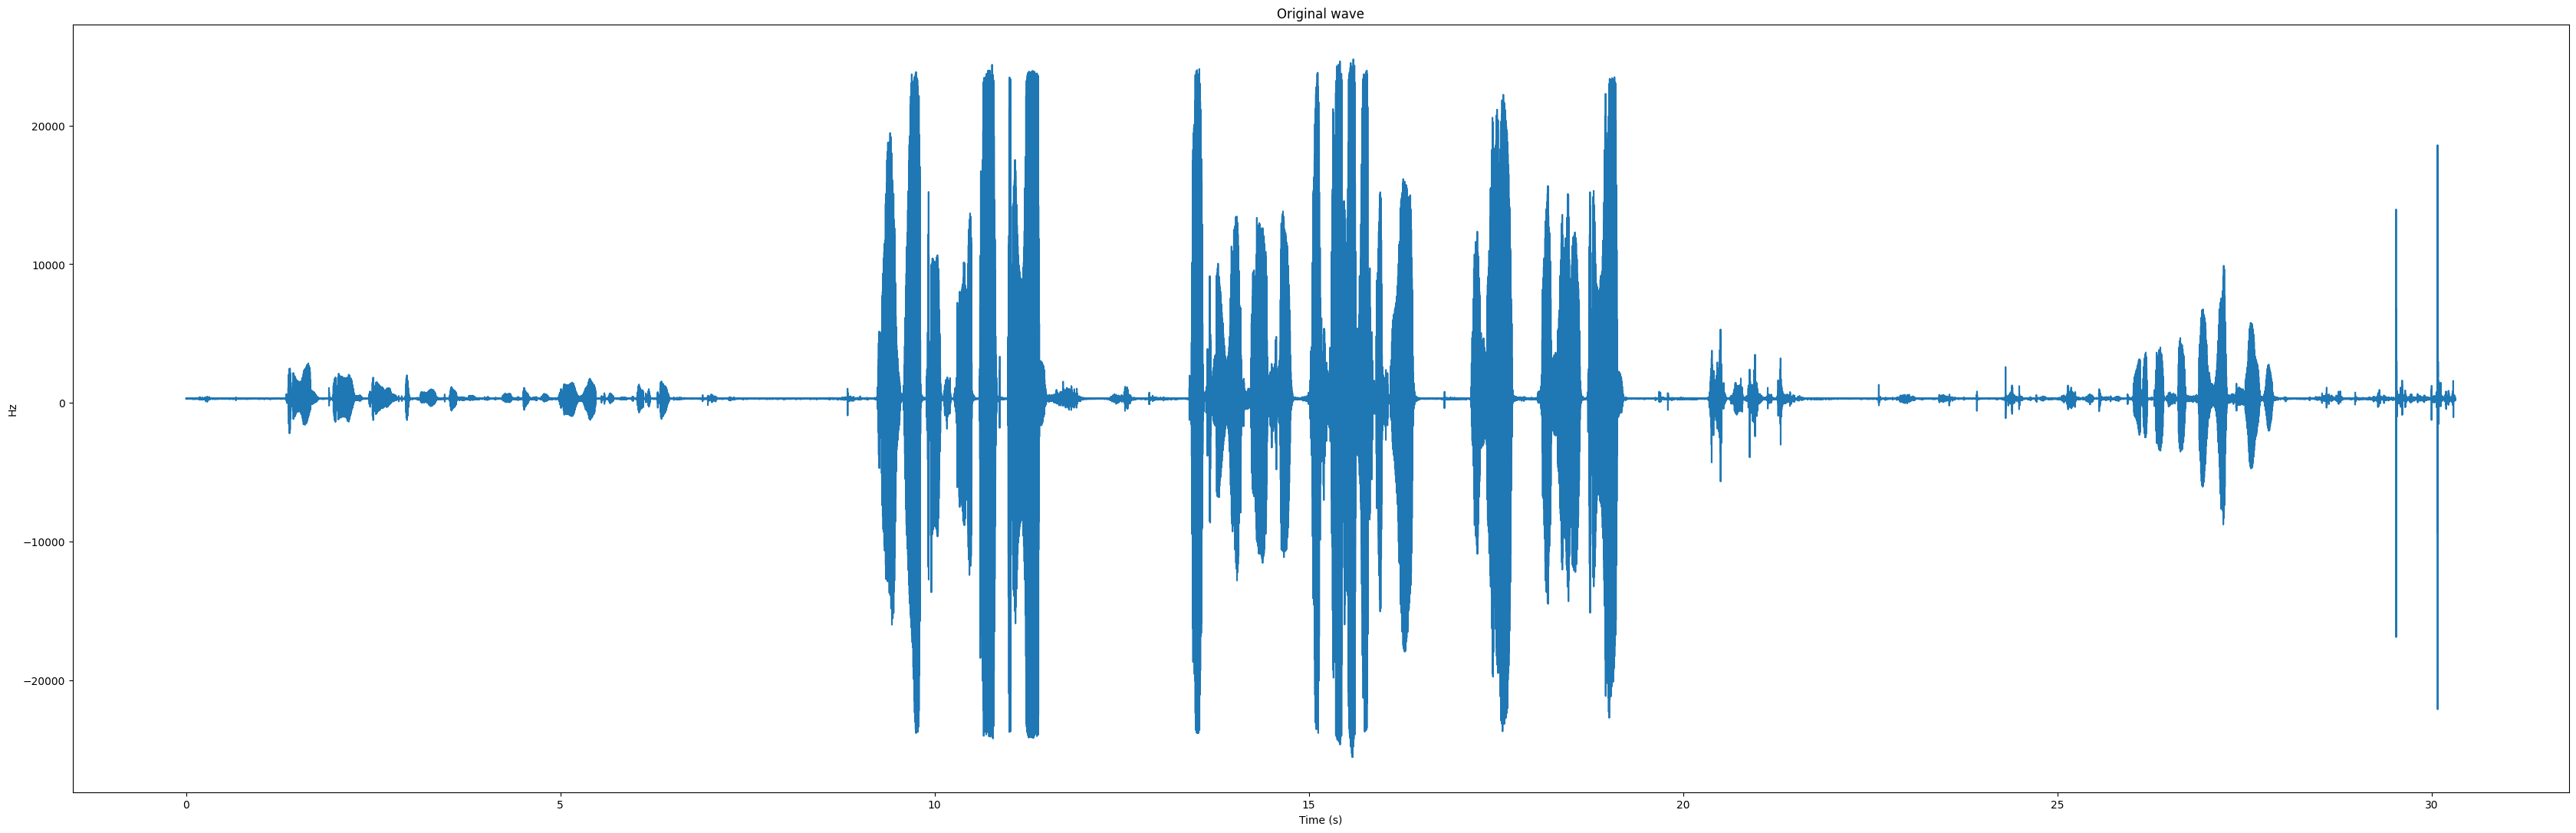

In [135]:
origPlotData = np.frombuffer(origData, np.int16)
origDataLen = len(origPlotData)
time = np.linspace(0, origDataLen / origRate, num = origDataLen)
plt.figure(figsize = FIG_SIZE)
plt.xlabel("Time (s)")
plt.ylabel("Hz")
plt.title("Original wave")
plt.plot(time, origPlotData)
plt.show()

In [136]:
def update_max(maxVal, val):
    if (val> maxVal):
        maxVal = val

def update_value(newVal: float, oldVal: float, val: float) -> float:
    return (val * newVal) + ((1.0 - val) * oldVal)

def frame_size(val1: int, val2: int) -> int:
    frameSize = int(round(float(val1) * (float(val2) / 1000.0)))
    return frameSize + (frameSize % 2)

def bound(threshold: float, val: float) -> float:
    return math.erf((math.sqrt(math.pi) / 2.0) * (val / threshold)) * threshold

def fade(prevVal: float, nextVal: float, pos: int, fadeFactors) -> float:
    return (fadeFactors[0][pos] * prevVal) + (fadeFactors[1][pos] * nextVal)

def limit(minVal, val, maxVal):
    return min(maxVal, max(minVal, val))

In [137]:
class GaussianFilter:
    m_sigma = float()
    m_weights = list()
    m_filterSize = int()
    
    def __init__(self, filterSize: int):
        self.m_filterSize = filterSize
        self.m_sigma = (((float(self.m_filterSize) / 2.0) - 1.0) / 3.0) + (1.0 / 3.0)
        self.m_weights = np.zeros(filterSize)
        totalWeight = 0.0
        offset = int(self.m_filterSize / 2)
        c1 = 1.0 / (self.m_sigma * np.sqrt(2.0 * np.pi))
        c2 = 2.0 * np.pow(self.m_sigma, 2.0)
    
        for i in range(0, self.m_filterSize):
            x = i - offset
            self.m_weights[i] = c1 * np.exp(np.pow(x, 2.0) * -1)
            totalWeight += self.m_weights[i]
    
        adjust = 1.0 / totalWeight
        for i in range(0, self.m_filterSize):
            self.m_weights[i] *= adjust
    
        print(f"filter size = {self.m_filterSize}, sigma = {self.m_sigma}")

    def apply(self, data: list[np.int16]) -> float:
        result = 0.0
        if (data.size() != self.m_filterSize):
            print("Input data wrong size")
            return result

        itr = 0
        for val in data:
            result += val * self.m_weights[itr]
            itr += 1
        
        return result


In [138]:
class AudioNormalizer:
    m_channels = int()
    m_sampleRate = int()
    m_frameLen = int()
    m_filterSize = int()
    m_prefillLen = int()
    m_delay = int()
    m_delayedSamples = int()
    
    m_peakVal = float()
    m_maxAmplification = float()
    m_targetRMS = float()

    m_altBoundaryMode = False

    m_gainHistoryOrig = np.array([], dtype = float)
    m_gainHistoryMin = np.array([], dtype = float)
    m_gainHistorySmooth = np.array([], dtype = float)
    m_prevAmplificationFactor = np.array([], dtype = float)
    m_dcCorrectionValue = np.array([], dtype = float)
    m_compressThreshold = np.array([], dtype = float)

    m_fadeFactors = None
    m_gauss = None

    def __init__(self, channels: int, sampleRate: int, frameLenMsec: int, filterSize: int,
                 peakValue: float, maxAmplification: float, targetRms: float, compressThresh: float, altBoundaryMode: bool):
        self.m_channels = channels
        self.m_sampleRate = sampleRate
        self.m_frameLen = frame_size(sampleRate, frameLenMsec)
        self.m_filterSize = limit(3, filterSize, 301)
        self.m_prefillLen = int(self.m_filterSize / 2)
        self.m_delay = self.m_frameLen * self.m_filterSize
        self.m_peakValue = limit(0.01, peakValue, 1.0)
        self.m_maxAmplification = limit(1.0, maxAmplification, 100.0)
        self.m_targetRMS = limit(0.0, targetRms, 1.0)
        self.m_altBoundaryMode = altBoundaryMode
        self.m_fadeFactors = np.zeros((2, self.m_frameLen))
        
        dStepSize = 1.0 / float(self.m_frameLen)
        for i in range(0, self.m_frameLen):
            self.m_fadeFactors[0][i] = (1.0 - (dStepSize * float(i + 1)))
            self.m_fadeFactors[1][i] = (1.0 - self.m_fadeFactors[0][i])

        m_gauss = GaussianFilter(FILTER_SIZE)

        print(f"Params:\n m_channels = {self.m_channels}\n m_sampleRate = {self.m_sampleRate}\n m_frameLen = {self.m_frameLen}\n m_filterSize = {self.m_filterSize}\n m_prefillLen = {self.m_prefillLen}\n m_delay = {self.m_delay}\n m_peakValue = {self.m_peakValue}\n m_maxAmplification = {self.m_maxAmplification}\n m_targetRMS = {self.m_targetRMS}\n m_altBoundaryMode = {self.m_altBoundaryMode}\n m_fadeFactors = {self.m_fadeFactors}")

    def process(self, data):
        # TODO: считывать данные по N байт
        pass
    
    def analyzeFrame(self, frame):
        self.performDCCorrection(frame, self.m_gainHistoryOrig.empty())
        for chnl in range(0, self.m_channels):
            self.updateGainHistory(chnl, self.getMaxLocalGain(frame, chnl))

    def amplifyFrame(self, frame):
        if (self.m_gainHistorySmooth.empty()):
            return

        currAmplificationFactor = self.m_gainHistorySmooth[0]
        del self.m_gainHistorySmooth[0]

        for i in range(0, self.m_frameLen):
            amplificationFactor = fade(self.m_prevAmplificationFactor[i], currAmplificationFactor, self.m_fadeFactors)
            frame[i] *= amplificationFactor
            if (math.fabs(frame[i]) > self.m_peakValue):
                frame[i] = math.copysign(self.m_peakValue, frame[i])

        self.m_prevAmplificationFactor[0] = currAmplificationFactor
    
    def getMaxLocalGain(self, frame, channel: int) -> float:
        maxGain = float(self.m_peakValue / self.findPeakMagnitude(frame, channel))
        rmsGain = (self.m_targetRMS / self.computeFrameRMS(frame, channel)) if (self.m_targetRMS > sys.float_info.epsilon) else sys.float_info.max
        return bound(self.m_maxAmplification, min(maxGain, rmsGain))

    def computeFrameRMS(self, frame, channel: int = None) -> float:
        rmsValue = 0.0

        if (None == channel):
            for i in range(0, self.m_frameLen):
                rmsValue += pow(frame[i], 2)
            rmsValue /= float(self.m_frameLen * self.m_channels)
        else:
            for i in range(0, self.m_frameLen):
                rmsValue += pow(frame[i], 2)
            rmsValue /= float(self.m_frameLen)

        return max(math.sqrt(rmsValue), sys.float_info.epsilon)

    def updateGainHistory(channel: int, currGainFactor: float):
        if (self.m_gainHistoryOrig.empty() or self.m_gainHistoryMin.empty()):
            initVal = currGainFactor if self.m_altBoundaryMode else 1.0
            self.m_prevAmplificationFactor[channel] = initVal
            while (self.m_gainHistoryOrig.size < self.m_prefillLen):
                self.m_gainHistoryOrig.append(initVal)
        
        self.m_gainHistoryOrig.append(currGainFactor)

        while (self.m_gainHistoryOrig.size < self.m_filterSize):
            if (self.m_gainHistoryMin.empty()):
                initVal = self.m_gainHistoryOrig.item(channel) if self.m_altBoundaryMode else 1.0
                inputVal = self.m_gainHistoryOrig.item(channel) + self.m_prefillLen
                
                while (self.m_gainHistoryMin.size < self.m_prefillLen):
                    initVal = min(initVal, inputVal) # NOTE: инкремент?
                    self.m_gainHistoryMin.append(initVal)

                minVal = min(self.m_gainHistoryOrig)
                del self.m_gainHistoryOrig[0]
                self.m_gainHistoryMin.append(minVal)

        while (self.m_gainHistoryMin.size >= self.m_filterSize):
            smoothed = self.m_gauss.apply(self.m_gainHistoryMin)
            del self.m_gainHistoryMin[0]
            self.m_gainHistorySmooth.append(smoothed)
        
    def performDCCorrection(self, data: list[np.int16], isFirstFrame: bool):
        diff = 1.0 / float(self.m_frameLen)
        currAvgVal = 0.0
        for i in range(0, self.m_frameLen):
            currAvgVal += (data[i] * diff)

        prevVal = currAvgVal if isFirstFrame else self.m_dcCorrectionValue
        self.m_dcCorrectionValue = currAvgVal if isFirstFrame else self.updateValue(currAvgVal, self.m_dcCorrectionValue, 0.1)

        for i in range(0, self.m_fameLen):
            data[i] -= self.fade(prevVal, self.m_dcCorrectionValue, i)

    def findPeakMagnitude(self, data: list[np.int16], channel: int) -> float:
        dMax = sys.float_info.epsilon
        for i in range(0, self.m_frameLen):
            self.update_max(dMax, math.fabs(data[i]))
        return dMax
        # if (None == channel):
        #     for i in range(0, self.m_frameLen):
        #         self.update_max(dMax, math.fabs(data[i]))
        # else:
        #     for i in range(0, self.m_frameLen):
        #         pass

    def setupCompressThresh(self, threshold: float) -> float:
        pass

In [143]:
def getFrameSize(sampleRate, frameLenMsec) -> int:
    frameSize = round(sampleRate * (frameLenMsec / 1000.0))
    return (frameSize + (frameSize % 2))

m_frameLen = getFrameSize(origRate, FRAME_LEN)
m_dcCorrectionValue = np.array([origCh], dtype = float)
m_prevAmplificationFactor = np.array([origCh], dtype = float)
m_fadeFactors = np.zeros((2, m_frameLen))
m_gainHistory_original = np.zeros(())
m_gainHistory_minimum = np.zeros(())
m_prefillLen = int(FILTER_SIZE / 2)
m_filterSize = FILTER_SIZE
# NOTE: первый фрейм, когда нажимаем тангенту? Когда отпускаем, сбрасываем значение
m_flag = True
m_altBoundaryMode = False

dStepSize = 1.0 / float(m_frameLen)
for i in range(0, m_frameLen):
    m_fadeFactors[0][i] = (1.0 - (dStepSize * float(i + 1)))
    m_fadeFactors[1][i] = (1.0 - m_fadeFactors[0][i])

def DC_correction(data, isFirstFrame: bool):
    diffVal = 1.0 / float(m_frameLen)
    for chnl in range(0, origCh):
        currentAverageValue = 0.0
        
        for i in range(0, m_frameLen):
            currentAverageValue += (data[i] * diffVal)
        
        prevValue = currentAverageValue if isFirstFrame else m_dcCorrectionValue[chnl]
        m_dcCorrectionValue[chnl] = currentAverageValue if isFirstFrame else update_value(currentAverageValue, m_dcCorrectionValue[chnl], 0.1)

        for i in range(0, m_frameLen):
            data[i] -= fade(prevValue, m_dcCorrectionValue[chnl], i, m_fadeFactors)

def updateGainHistory(channel: int, currentGainFactor: float):
    global m_gainHistory_original
    global m_altBoundaryMode
    
    if (m_gainHistory_original.size == 0 or m_gainHistory_minimum.size == 0):
        initial_value = currentGainFactor if m_altBoundaryMode else 1.0
        m_prevAmplificationFactor[channel] = initial_value
        while (m_gainHistory_original.size < m_prefillLen):
            m_gainHistory_original.append(initial_value)

    m_gainHistory_original.append(currentGainFactor)

    while (m_gainHistory_original.size >= m_filterSize):
        if (m_gainHistory_minimum.size == 0):
            initial_value = currentGainFactor if m_gainHistory_original[0] else 1.0
            inputVal = m_gainHistory_original[0 + m_prefillLen + 1] # вместо прединкремента
            while (m_gainHistory_minimum.size < m_prefillLen):
                initial_value = min(initial_value, inputVal)
                m_gainHistory_minimum.append(initial_value)

        minVal = min(m_gainHistory_original)
        del m_gainHistory_original[0]
        m_gainHistory_minimum.append(minVal)

def analyzeFrame(frame):
    global m_flag
    DC_correction(frame, m_flag)
    m_flag = False
    for ch in range(0, origCh):
        updateGainHistory(ch, getMaxLocalGain(frame, ch))

In [144]:
# audioNorm = AudioNormalizer(origCh, origRate, 160, FILTER_SIZE, 1, 100, 0.0, 0.0, False)

processedData = np.array(origPlotData, copy = True)
processedData = processedData.astype(np.int64)

for i in range(0, len(processedData), m_frameLen):
    if (i+m_frameLen < len(processedData)):
        analyzeFrame(processedData[i:i+m_frameLen])

processedData = processedData.astype(np.int16)
print(all(x in processedData for x in origPlotData))

False


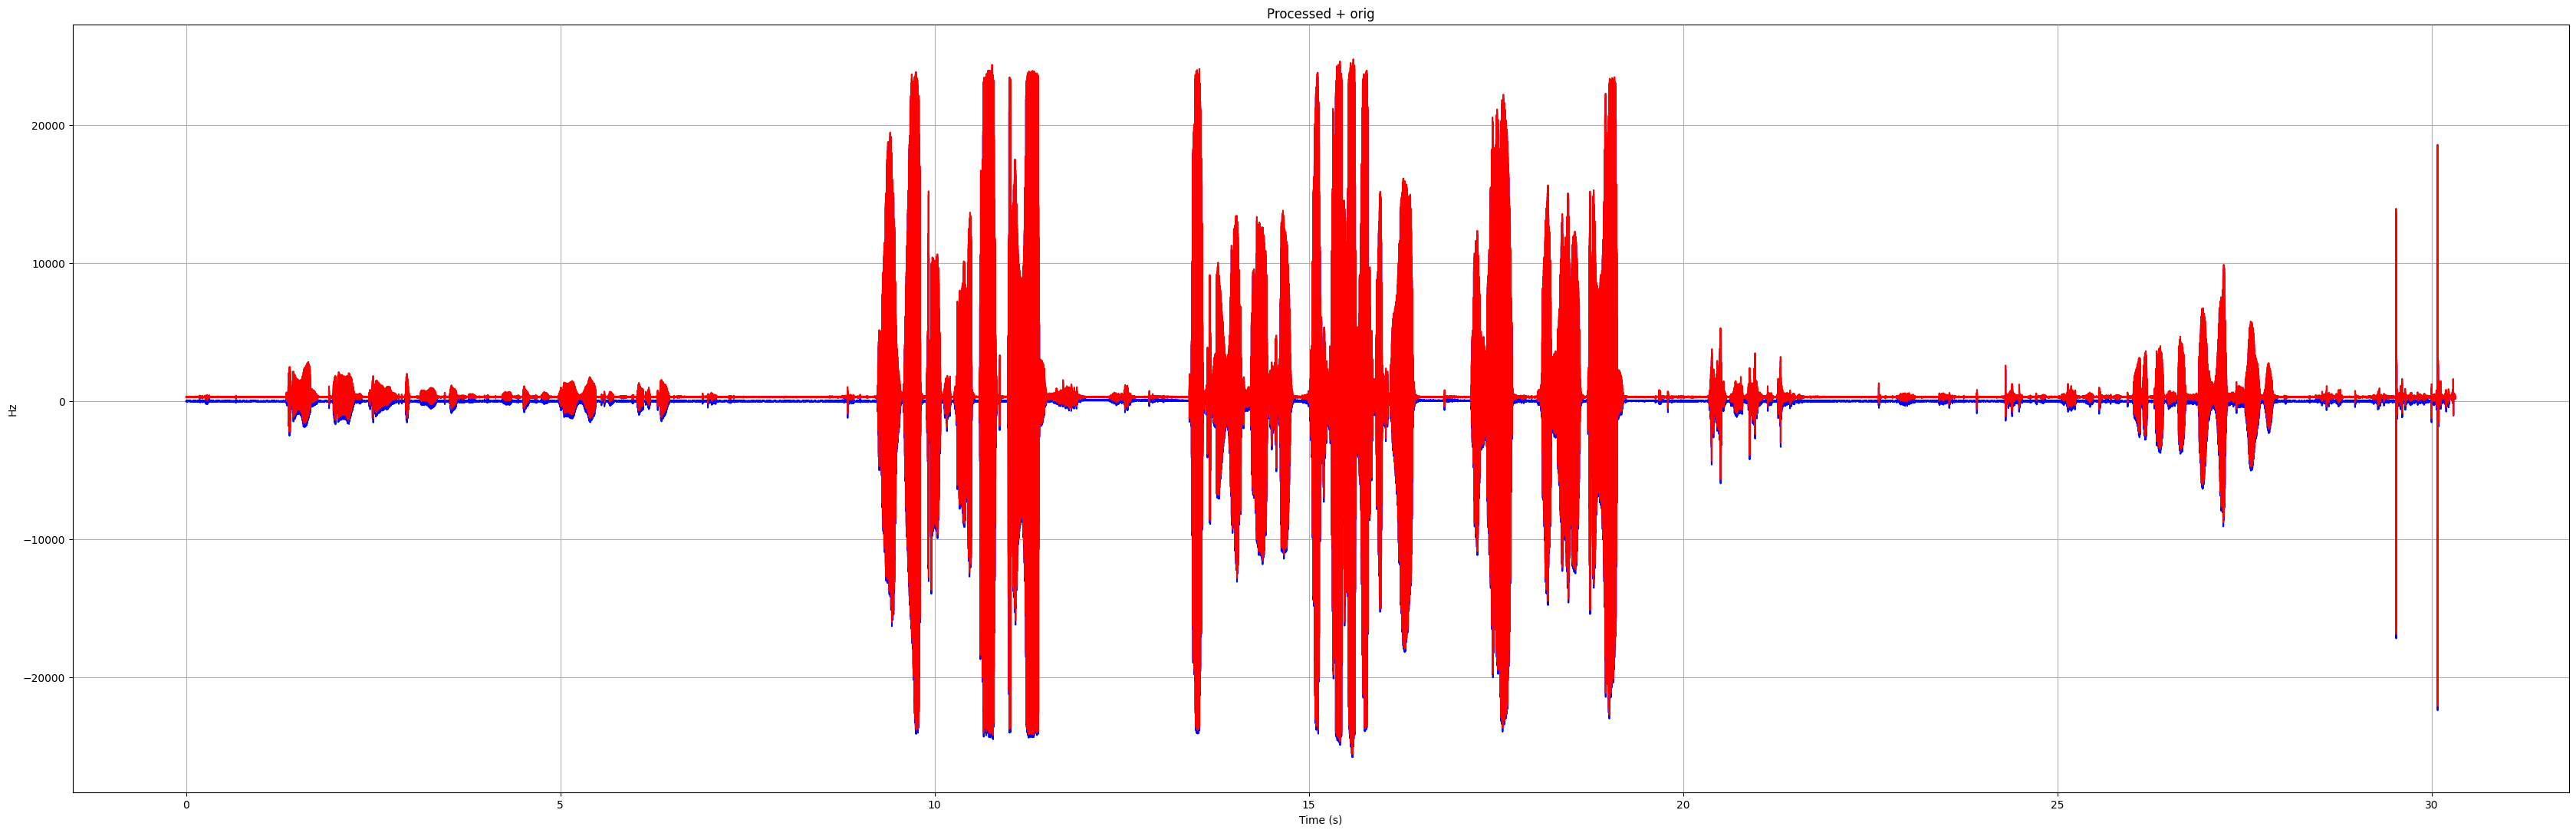

In [145]:
plt.figure(figsize = FIG_SIZE)
plt.xlabel("Time (s)")
plt.ylabel("Hz")
plt.title("Processed + orig")
plt.plot(time, processedData, color = 'b')
plt.plot(time, origPlotData, color = 'r')
plt.grid(True)
plt.show()